# ShapeFactor

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging
import json

import pyhf
from pyhf import hfpdf

logging.basicConfig(level = logging.INFO)

In [3]:
def prep_data(sourcedata):
    spec =  {
        'channels': [
            {
                'name': 'signal',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sourcedata['signal']['bindata']['sig'],
                        'modifiers': [
                            {
                                'name': 'mu',
                                'type': 'normfactor',
                                'data': None
                            }
                        ]
                    },
                    {
                        'name': 'bkg1',
                        'data': sourcedata['signal']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_shapefactor',
                                'type': 'shapefactor',
                                'data': None
                            }
                        ]
                    }
                ]
            },
            {
                'name': 'control',
                'samples': [
                    {
                        'name': 'background',
                        'data': sourcedata['control']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_shapefactor',
                                'type': 'shapefactor',
                                'data': None
                            }
                        ]
                    }
                ]
            }
        ]
    }
    pdf  = hfpdf(spec)
    data = []
    for c in pdf.spec['channels']:
        data += sourcedata[c['name']]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [4]:
source = {
  "channels": {
    "signal": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":     [220.0, 230.0],
        "bkg1":     [100.0, 70.0],
        "sig":      [ 20.0, 20.0]
      }
    },
    "control": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":    [200.0, 300.0],
        "bkg1":    [100.0, 100.0]
      }
    }
  }
}

data, pdf = prep_data(source['channels'])
print('data: {}'.format(data))

init_pars = pdf.config.suggested_init()
print('expected data: {}'.format(pdf.expected_data(init_pars)))

par_bounds = pdf.config.suggested_bounds()

INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:adding modifier coupled_shapefactor (2 new nuisance parameters)
INFO:pyhf:using existing shared, unconstrained modifier (name=coupled_shapefactor, type=shapefactor)


data: [220.0, 230.0, 200.0, 300.0]
expected data: [120.  90. 100. 100.]


In [5]:
print('initialization parameters: {}'.format(pdf.config.suggested_init()))

unconpars = pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav, data, pdf,
                                                 pdf.config.suggested_init(), pdf.config.suggested_bounds())
print('parameters post unconstrained fit: {}'.format(unconpars))

initialization parameters: [1.0, 1.0, 1.0]
parameters post unconstrained fit: [1.00004623 1.99998941 3.00000438]


/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:96: RuntimeWarning: divide by zero encountered in log
/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:71: RuntimeWarning: divide by zero encountered in log


/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:96: RuntimeWarning: divide by zero encountered in log
/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:71: RuntimeWarning: divide by zero encountered in log
/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:62: RuntimeWarning: invalid value encountered in sqrt
/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/__init__.py:351: RuntimeWarning: divide by zero encountered in true_divide
  oneOverCLs = CLb / CLsb


{'exp': [0.7413811356064698,
  0.9949349808658932,
  1.3845138849641385,
  1.9289937767647345,
  2.5940766281884247],
 'obs': 2.1945969282055913}

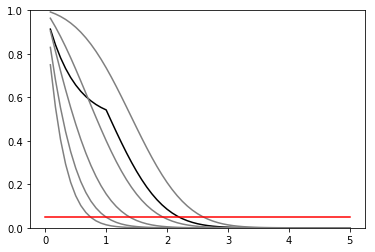

In [6]:
def plot_results(testmus, cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests, cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def invert_interval(testmus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size,
                                             list(reversed(yvals)),
                                             list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,
                                    list(reversed(yvals)),
                                    list(reversed(testmus)))
    return point05cross


pyhf.runOnePoint(1.0, data, pdf, init_pars,par_bounds)[-2:]


mutests = np.linspace(0, 5, 61)
tests = [pyhf.runOnePoint(muTest, data, pdf, init_pars, par_bounds)[-2:] for muTest in mutests]
cls_obs = np.array([test[0] for test in tests]).flatten()
cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]

print('\n')
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)